<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calculating-Seasonal-Averages-from-Timeseries-of-Monthly-Means-" data-toc-modified-id="Calculating-Seasonal-Averages-from-Timeseries-of-Monthly-Means--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculating Seasonal Averages from Timeseries of Monthly Means </a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Some-calendar-information-so-we-can-support-any-netCDF-calendar." data-toc-modified-id="Some-calendar-information-so-we-can-support-any-netCDF-calendar.-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>Some calendar information so we can support any netCDF calendar.</a></span></li><li><span><a href="#A-few-calendar-functions-to-determine-the-number-of-days-in-each-month" data-toc-modified-id="A-few-calendar-functions-to-determine-the-number-of-days-in-each-month-1.0.0.2"><span class="toc-item-num">1.0.0.2&nbsp;&nbsp;</span>A few calendar functions to determine the number of days in each month</a></span></li><li><span><a href="#Open-the-Dataset" data-toc-modified-id="Open-the-Dataset-1.0.0.3"><span class="toc-item-num">1.0.0.3&nbsp;&nbsp;</span>Open the <code>Dataset</code></a></span></li><li><span><a href="#Now-for-the-heavy-lifting:" data-toc-modified-id="Now-for-the-heavy-lifting:-1.0.0.4"><span class="toc-item-num">1.0.0.4&nbsp;&nbsp;</span>Now for the heavy lifting:</a></span></li></ul></li></ul></li></ul></li></ul></div>

Calculating Seasonal Averages from Timeseries of Monthly Means 
=====

Author: [Joe Hamman](https://github.com/jhamman/)

The data used for this example can be found in the [xray-data](https://github.com/xray/xray-data) repository. You may need to change the path to `rasm.nc` below.

Suppose we have a netCDF or xray Dataset of monthly mean data and we want to calculate the seasonal average. To do this properly, we need to calculate the weighted average considering that each month has a different number of days.

Suppose we have a netCDF or `xarray.Dataset` of monthly mean data and we want to calculate the seasonal average.  To do this properly, we need to calculate the weighted average considering that each month has a different number of days.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import num2date
import matplotlib.pyplot as plt 

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

numpy version  :  1.14.3
pandas version :  0.23.4
xarray version :  0.11.0+10.gc01767ce


#### Some calendar information so we can support any netCDF calendar.  

In [2]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]} 

#### A few calendar functions to determine the number of days in each month
If you were just using the standard calendar, it would be easy to use the `calendar.month_range` function.

In [3]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)
    
    cal_days = dpm[calendar]
    
    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

#### Open the `Dataset`

In [4]:
ds = xr.tutorial.open_dataset('rasm').load()
print(ds)

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 29.8 28.66 28.19 28.21
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue D

#### Now for the heavy lifting:
We first have to come up with the weights,
- calculate the month lengths for each monthly data record
- calculate weights using `groupby('time.season')`

Finally, we just need to multiply our weights by the `Dataset` and sum allong the time dimension.  

In [5]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='noleap'),
                            coords=[ds.time], name='month_length')

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby('time.season').sum(dim='time')

In [6]:
print(ds_weighted)

<xarray.Dataset>
Dimensions:  (season: 4, x: 275, y: 205)
Coordinates:
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: x, y
Data variables:
    Tair     (season, y, x) float64 0.0 0.0 0.0 0.0 ... 23.15 22.08 21.73 21.96


In [7]:
# only used for comparisons
ds_unweighted = ds.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

/home/deepak/work/python/xarray/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

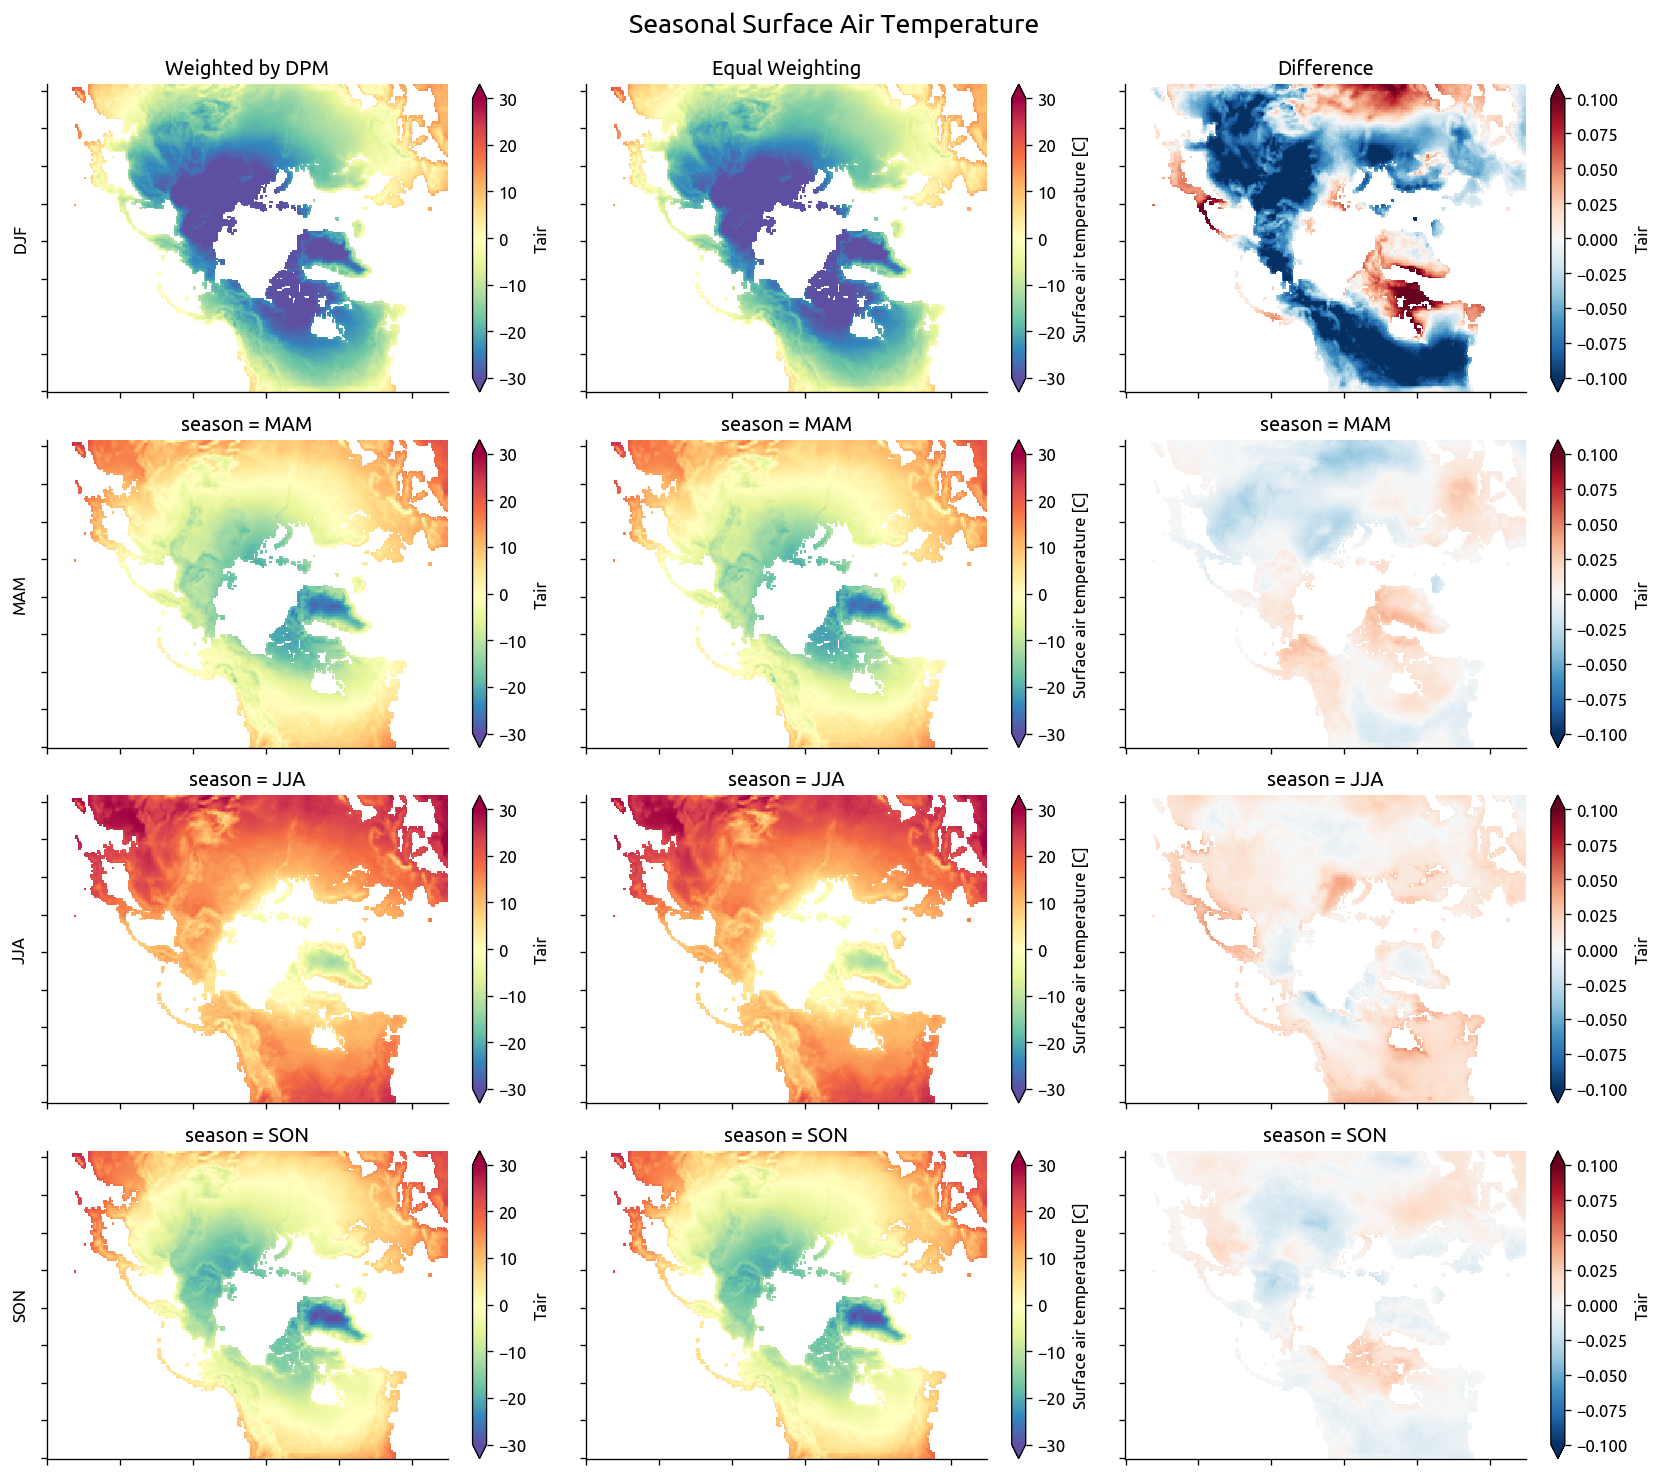

In [8]:
# Quick plot to show the results
notnull = pd.notnull(ds_unweighted['Tair'][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=-30, vmax=30, cmap='Spectral_r', 
        add_colorbar=True, extend='both')
    
    ds_unweighted['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=-30, vmax=30, cmap='Spectral_r', 
        add_colorbar=True, extend='both')

    ds_diff['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    
axes[0, 0].set_title('Weighted by DPM')
axes[0, 1].set_title('Equal Weighting')
axes[0, 2].set_title('Difference')
        
plt.tight_layout()

fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)

In [9]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
    year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                               coords=[ds.time], name='year_season')

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')